# Notes about simulation:

**Running info**
- 2250 simulations
- week queue

**EA params**
- 160 generations
- 250 individuals
- 0.1 mutation rate
- 0.5 crossover rate

**Parameter search space**
- beta_0,    k1, k3, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8
- minimums = [ -4,   -2, -2, -2, -2,   -2, -2, -2, -2,   -2, -2,     -2, -2, -2, -2,    -2, -2, -2, -2]
- maximums = [4.5,    4,  4,  4,  4,    4,  4,  4,  4,    4,  4,     4,   4,  4,  4,     4,  4,  4,  4]

**Mean of Mean Square Error of the top 2.5% of Individuals** 
- 1404.57196018


$$MAP3K_I = MAP3K_t-MAP3K$$
$$MAP2K_I = MAP2K_t-MAP2K$$
$$MAPK_I = MAPK_t-MAPK$$
$$X_I = X_t-X$$
$$Y_I = Y_t-Y$$


$$\dfrac{dMAP3K}{dt} = \dfrac{ s}{1+\dfrac{Y}{\beta}} \cdot \dfrac{\Big(k1 + \alpha\cdot MAPK \Big) \cdot MAP3K_I}{K_1 + MAP3K_I} - \dfrac{k2\cdot MAP3K}{K_2+MAP3K}$$

$$\dfrac{dMAP2K}{dt} = \dfrac{k3\cdot MAP3K\cdot MAP2K_I}{K_3 + MAP2K_I} - \dfrac{k4\cdot MAP2K}{K_4+MAP2K}$$

$$\dfrac{dMAPK}{dt} = \dfrac{k5\cdot MAP2K\cdot MAPK_I}{K_5 + MAPK_I} - \dfrac{k6\cdot MAPK}{K_6+MAPK}$$

$$\dfrac{dX}{dt} = \dfrac{k7\cdot MAPK\cdot X_I}{K_7 + X_I} - \dfrac{k9\cdot MAPK}{K_9+Y}$$

$$\dfrac{dY}{dt} = \dfrac{k9\cdot X\cdot Y_I}{K_9 + Y_I} - \dfrac{k10\cdot MAPK}{K_10+X}$$


# Import packages and set settings

In [1]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import math
import pandas as pd
from scipy.integrate import odeint
import os

In [2]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

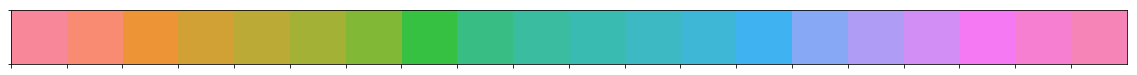

In [3]:
sns.palplot(sns.husl_palette(20, l=.7))
palette_husl = sns.husl_palette(20, l=.7)
# palette_husl.as_hex()

# Load data to fit to

In [4]:
wt_folder = '../data/MAPK activation/WT'
t100a_folder = '../data/MAPK activation/T100A'

def load_csv_data(folder):
    data = []
    for csv in pathlib.Path(folder).glob('*.csv'):
        f_data = pd.read_csv(csv)
        time = f_data['Time'].tolist()
        f_data=f_data.set_index('Time')
        f_data = f_data.mean(axis=1)
        f_data = f_data.tolist()
        data.append(f_data)
    return time, data

mapk_time, mapk_wt_data = load_csv_data(wt_folder)
mapk_time, mapk_t100a_data = load_csv_data(t100a_folder)

scorefxn_data = [mapk_wt_data, mapk_t100a_data]

# Supporting Functions

In [5]:
# def scorefxn1(scorefxn_time, scorefxn_data, inits, params_constants,
#               learned_params, time, plot_bool):
#     mse_total = 0
#     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

#     for sig, MAPK_wt_data, MAPK_t100a_data in zip(params_constants[-1], scorefxn_data[0], scorefxn_data[1]):
#         params_constants = params_constants[:-1]+[sig]

#         # WT simulation
#         data = simulate_wt_experiment(inits, params_constants, arr_params_IP, time)
#         active = (data[:,2] + data[:,3])/params_constants[2]*100
#         # get index of time points closest
#         idx_closest_time_points = []
#         for each_time in scorefxn_time:
#             closest_idx = min(range(len(time)),
#                               key = lambda i: abs(time[i] - each_time))
#             idx_closest_time_points.append(closest_idx)
#         # use indexes of time points to get data points to score against
#         _scorefxn_data_active = active[[idx_closest_time_points]]
#         error_active = ((MAPK_wt_data - _scorefxn_data_active)**2).mean()
#         mse_total += error_active

#         # T100A simulation
#         data = simulate_t100a_experiment(inits, params_constants, arr_params_IP, time)
#         active = (data[:,2] + data[:,3])/params_constants[2]*100
#         idx_closest_time_points = []
#         for each_time in scorefxn_time:
#             closest_idx = min(range(len(time)),
#                               key = lambda i: abs(time[i] - each_time))
#             idx_closest_time_points.append(closest_idx)
#         _scorefxn_data_active = active[[idx_closest_time_points]]
#         error_active = ((MAPK_t100a_data - _scorefxn_data_active)**2).mean()
#         mse_total += error_active
#     return mse_total


# def scorefxn_helper(individual):
#     # just a helper function that pulls all of scorefxn1 dependencies together
#     # note the (), <--using single optimization in DEAP for now
#     # scorefxn1 is taking care of the multiple optimizations for now
#     return scorefxn1(mapk_time, scorefxn_data, inits, params_constants, individual, time, False),

def molarity_conversion(molecules):
    Na = 6.02214076*10**23
    cell_volume = 44
    return molecules/(Na*cell_volume*10**-15)*100000

# No delay - uM

## Functions

In [6]:
def b0_0D(initals,t,params_constants,params):
    MAP3K, MAP2K, MAPK = initals
    MAP3K_t, MAP2K_t, MAPK_t, fb, s = params_constants
    beta_0, k1, k3, k5, k2, k4, k6, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (s/(1+(MAPK/beta_0))**fb) * ((k1)*MAP3K_I / (K_1 + MAP3K_I)) - ((k2   )*MAP3K / (K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I) / (K_3 + MAP2K_I)) - ((k4   )*MAP2K / (K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I) / (K_5 + MAPK_I)) - ((k6   )*MAPK / (K_6+MAPK))

    return dMAP3K, dMAP2K, dMAPK

def simulate_wt_experiment_0D(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b0_0D, inits, time, args=(params_constants, learned_params))

    return odes

def simulate_t100a_experiment_0D(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    MAP3K_t, MAP2K_t, MAPK_t, fb, s = params_constants
    params_constants = MAP3K_t, MAP2K_t, MAPK_t, t100a_fb, s
    
#     beta_0, k1, k3, k5, k2, k4, k6, K_1, K_3, K_5, K_2, K_4, K_6 = learned_params
#     learned_params = beta_0, k1, k3, k5, k2, k4, k6, K_1, K_3, K_5, K_2, K_4, K_6

    #solve odes:
    odes = odeint(b0_0D, inits, time, args=(params_constants, learned_params))

    return odes

## Inputs

In [7]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/180917_b0_0D_b0_uM'

gen = 500
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
# X = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
# X_t=100

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['B0',
              'k1', 'k3', 'k5', 
              'k2', 'k4', 'k6',
              'K1', 'K3', 'K5',
              'K2', 'K4', 'K6'
                ]

mins = [ -4,   -4, -4, -4,    -4, -4, -4,     -4, -4, -4,    -4, -4, -4]

maxs = [4,    4,  4,  4,     4,  4,  4,      4,  4,  4,     4,  4,  4]

diff = np.asarray(maxs)-np.asarray(mins)

fb = 1
t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, fb, s] 

# Parameter's being learned
# params = beta_0, alpha_2,    k1, k3, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

## Gather simulated data

In [8]:
mse = []
params_from_file = []

empty_data = 0
for loaded_data in pathlib.Path(folder).glob('*.pickled'):
    if os.path.getsize(loaded_data) > 0:
        with open(loaded_data, 'rb') as f:
            new_data = pickle.load(f)
            mse.append(np.asarray(new_data[0]))
            params_from_file.append(np.asarray(new_data[1]))
    else:
        empty_data += 1

top = round((runs-empty_data)*0.05)
plt_top = round((runs-empty_data)*0.01)      
    
new_params = []
last_mses = []
for i in range(len(params_from_file)):
    new_params.append(params_from_file[i][gen])
    last_mses.append(mse[i][gen])
last_mses = np.asarray(last_mses)
new_params = np.asarray(new_params)
new_params = new_params.T

idx_top = last_mses.argsort()[:top]

top_params = [([new_params[i][x] for i in range(len(new_params))]) for x in idx_top]
# top_params = []
# for idx in idx_top:
#     top_params.append(params_from_file[idx][100])

print('Best MSE: ' + str(np.min([mse[idx][gen] for idx in idx_top])))

Best MSE: 20888.8848199


In [9]:
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

## Plot

# of unstable WT experiments: 0 of 120
# of unstable T100A experiments: 0 of 120


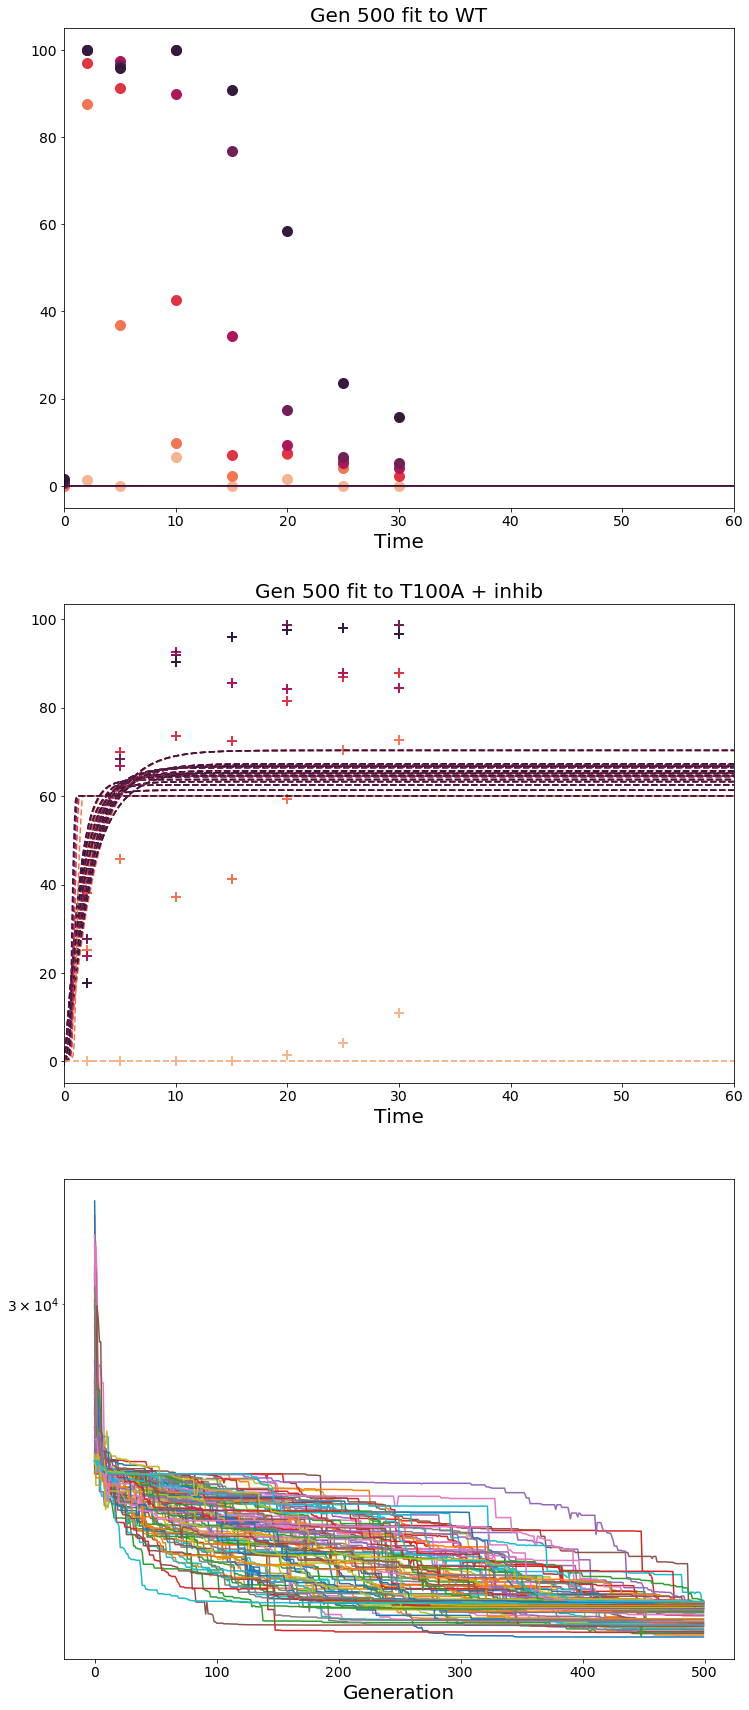

In [10]:
#initialize figure:
plt.clf()
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(12,30))


#plot 1
title_text = 'Gen ' + str(gen) + ' fit to WT'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
color_palette = sns.color_palette("rocket", 6)[::-1]

# plot real data:
for idx, wt_data in enumerate(mapk_wt_data):
    ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
#     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
unstable = 0
for idx in idx_top[:plt_top]:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment_0D(initals, params_c, learned_params, time)
        active = (data[:,2])/params_constants[2]*100
        active = data[:,2]
        if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            ax1.plot(time, active, color=color_palette[idx])
        else:
            unstable += 1
# ax1.set_ylim(0, 100)
ax1.set_xlim(0,60)
print('# of unstable WT experiments: ' + str(unstable) + ' of ' + str(plt_top*6))
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  ' fit to T100A + inhib'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

for idx, t100a_data in enumerate(mapk_t100a_data):
    ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
unstable = 0
for idx in idx_top[:plt_top]:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment_0D(initals, params_c, learned_params, time)
        active = (data[:,2])/params_constants[2]*100
        if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
        else:
            unstable += 1
# ax1.set_ylim(0, 100)
ax2.set_xlim(0,60)
print('# of unstable T100A experiments: ' + str(unstable) + ' of ' + str(plt_top*6))
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#plot2    
ax3.set_xlabel('Generation', fontsize=20)
# ax2.set_ylabel('Sum of MSE', fontsize=20)
# ax3.set_yscale('log')
# ax2.set_xlim([0,gen])
# ax2.set_ylim([10**3,10**5])
for idx in idx_top:
    ax3.semilogy([x for x in range(gen)], mse[idx][:gen])
    

plt.show()

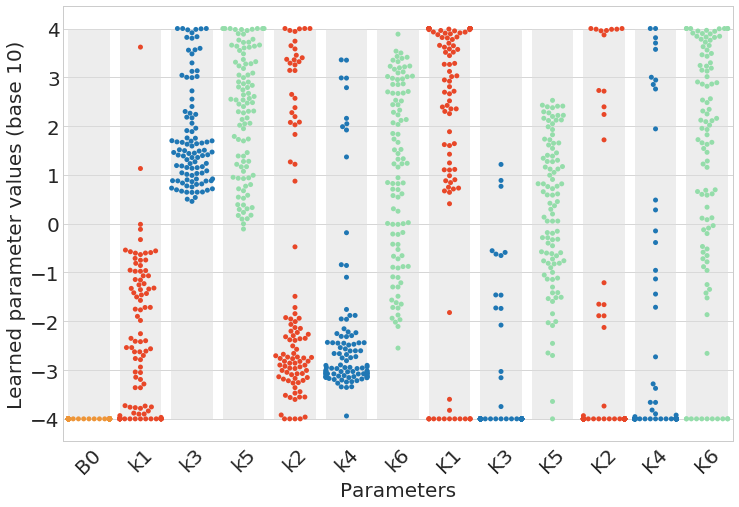

In [11]:
plt.rcParams['figure.figsize'] = [12.0, 8.0]

# positive 3db7d6
# negative ee9537
# hog1 ? 38bf85 or 94ddaa

colors = ['#ee9537',
          '#e84728','#1f77b4','#94ddaa',
          '#e84728','#1f77b4','#94ddaa',
          '#e84728','#1f77b4','#94ddaa',
          '#e84728','#1f77b4','#94ddaa']

pal = sns.set_palette(colors)

with sns.axes_style("whitegrid"):
    plt.bar(range(0,len(labelnames)),height=diff,bottom=mins,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
    x = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M)
    x.set_xticklabels(labelnames,rotation=45)
#     ax.set_yscale("log")
#     ax.set_ylim(0.00001,100000)
#     ax4.set_xticks(locs)
#     plt.xticklabels(labelnames, fontsize=18, rotation=90)
    plt.xlabel('Parameters', fontsize=20)
    plt.ylabel('Learned parameter values (base 10)', fontsize=20)
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

(array([  15.,   22.,   56.,   82.,   78.,   91.,  192.,  155.,  228.,
         175.,  241.,  212.,  394.,   23.,   36.]),
 array([ 20888.88481985,  21159.29369499,  21429.70257014,  21700.11144528,
         21970.52032042,  22240.92919556,  22511.3380707 ,  22781.74694584,
         23052.15582098,  23322.56469612,  23592.97357126,  23863.3824464 ,
         24133.79132154,  24404.20019668,  24674.60907183,  24945.01794697]),
 <a list of 15 Patch objects>)

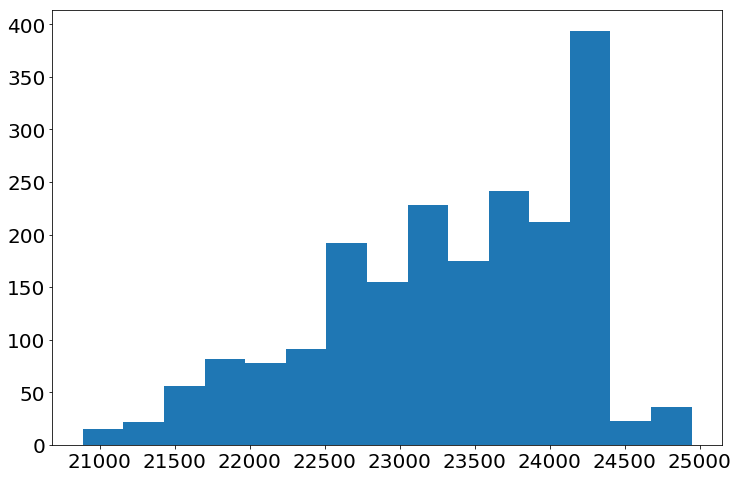

In [12]:
plt.hist(last_mses,bins=15,color='#1f77b4')

# One step delay - uM

## Functions

In [17]:
def b0_1D(initals,t,params_constants,params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t, X_t, s = params_constants 
    beta_0,    k1, k3, k5, k7,    k2, k4, k6, k8,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8 = params
    
    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    X_I = X_t-X
    
    dMAP3K = ((k1*s)/(1+X/beta_0)) * (MAP3K_I / (K_1 + MAP3K_I)) - (k2*MAP3K / (K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I) / (K_3 + MAP2K_I)) - (k4*MAP2K / (K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I) / (K_5 + MAPK_I)) - (k6*MAPK / (K_6+MAPK))
    dX = ((k7*MAPK*X_I) / (K_7 + X_I)) - (k8*X / (K_8+X))
    
    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_wt_experiment_1D(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b0_1D, inits, time, args=(params_constants, learned_params))

    return odes

def simulate_t100a_experiment_1D(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_0, k1, k3, k5, k7, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8 = learned_params
    learned_params = beta_0, k1, k3, k5, 0, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8

    #solve odes:
    odes = odeint(b0_1D, inits, time, args=(params_constants, learned_params))

    return odes

## Inputs

In [18]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/180917_b0_1D_k7_uM'

gen = 500
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t=100

print(MAPK_t)

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['B0',
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'K7',
              'K1', 'K3', 'K5', 'k8',
              'K2', 'K4', 'K6', 'K8'
                ]

mins = [ -4,   -4, -4, -4, -4,    -4, -4, -4, -4,     -4, -4, -4, -4,    -4, -4, -4, -4]

maxs = [4,    4,  4,  4,  4,     4,  4,  4,  4,      4,  4,  4,  4,     4,  4,  4,  4]

diff = np.asarray(maxs)-np.asarray(mins)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, s] 
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

0.02258333131356431


## Gather simulated data

In [19]:
mse = []
params_from_file = []

empty_data = 0
for loaded_data in pathlib.Path(folder).glob('*.pickled'):
    if os.path.getsize(loaded_data) > 0:
        with open(loaded_data, 'rb') as f:
            new_data = pickle.load(f)
            mse.append(np.asarray(new_data[0]))
            params_from_file.append(np.asarray(new_data[1]))
    else:
        empty_data += 1

top = round((runs-empty_data)*0.05)
plt_top = round((runs-empty_data)*0.01)   
print('Plotting top ' +str(plt_top)+' runs')
    
new_params = []
last_mses = []
for i in range(len(params_from_file)):
    new_params.append(params_from_file[i][gen])
    last_mses.append(mse[i][gen])
last_mses = np.asarray(last_mses)
new_params = np.asarray(new_params)
new_params = new_params.T

idx_top = last_mses.argsort()[:top]

top_params = [([new_params[i][x] for i in range(len(new_params))]) for x in idx_top]
# top_params = []
# for idx in idx_top:
#     top_params.append(params_from_file[idx][100])

print('Best MSE: ' + str(np.min([mse[idx][gen] for idx in idx_top])))

Plotting top 20 runs
Best MSE: 19439.0642928


In [20]:
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

## Plot

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# of unstable WT experiments: 0 of 120
# of unstable T100A experiments: 0 of 120


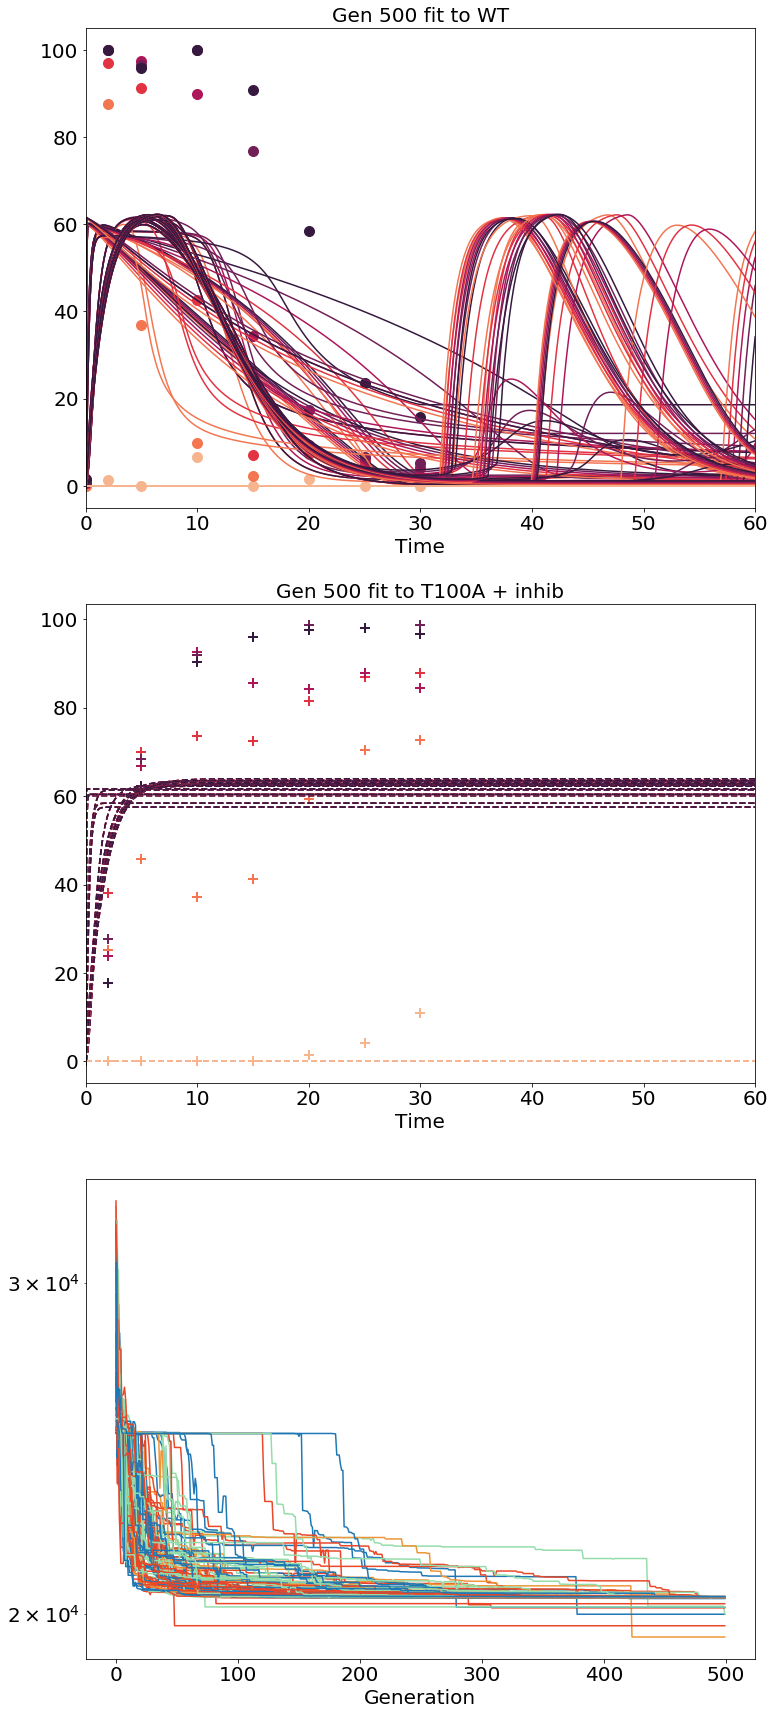

In [21]:
#initialize figure:
plt.clf()
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(12,30))


#plot 1
title_text = 'Gen ' + str(gen) + ' fit to WT'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
color_palette = sns.color_palette("rocket", 6)[::-1]

# plot real data:
for idx, wt_data in enumerate(mapk_wt_data):
    ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
#     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
unstable = 0
for idx in idx_top[:plt_top]:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment_1D(initals, params_c, learned_params, time)
        active = data[:,2]/params_constants[2]*100
        if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            ax1.plot(time, active, color=color_palette[idx])
        else:
            unstable += 1
# ax1.set_ylim(0, 100)
ax1.set_xlim(0,60)
print('# of unstable WT experiments: ' + str(unstable) + ' of ' + str(plt_top*6))
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  ' fit to T100A + inhib'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

for idx, t100a_data in enumerate(mapk_t100a_data):
    ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
unstable = 0
for idx in idx_top[:plt_top]:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment_1D(initals, params_c, learned_params, time)
        active = data[:,2]/params_constants[2]*100
        if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
        else:
            unstable += 1
# ax1.set_ylim(0, 100)
ax2.set_xlim(0,60)
print('# of unstable T100A experiments: ' + str(unstable) + ' of ' + str(plt_top*6))
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#plot2    
ax3.set_xlabel('Generation', fontsize=20)
# ax2.set_ylabel('Sum of MSE', fontsize=20)
# ax3.set_yscale('log')
# ax2.set_xlim([0,gen])
# ax2.set_ylim([10**3,10**5])
for idx in idx_top:
    ax3.semilogy([x for x in range(gen)], mse[idx][:gen])
    

plt.show()

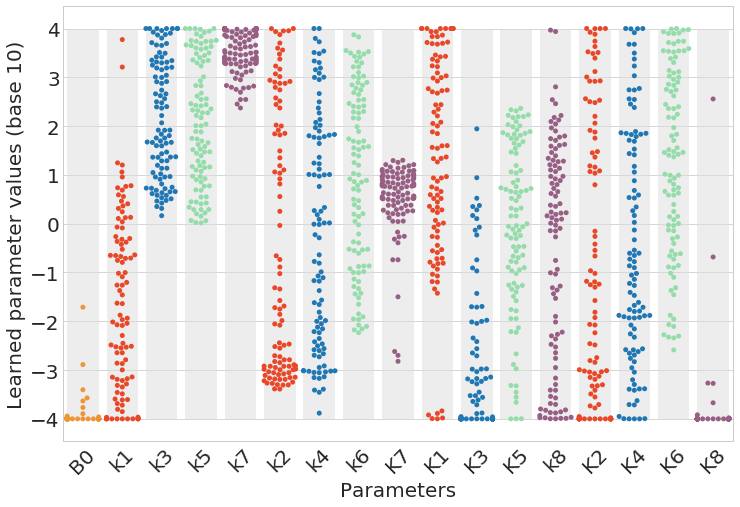

In [22]:
plt.rcParams['figure.figsize'] = [12.0, 8.0]

# positive 3db7d6
# negative ee9537
# hog1 ? 38bf85 or 94ddaa

colors = ['#ee9537',
          '#e84728','#1f77b4','#94ddaa','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85']

pal = sns.set_palette(colors)

with sns.axes_style("whitegrid"):
    plt.bar(range(0,len(labelnames)),height=diff,bottom=mins,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
    x = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M)
    x.set_xticklabels(labelnames,rotation=45)
#     ax.set_yscale("log")
#     ax.set_ylim(0.00001,100000)
#     ax4.set_xticks(locs)
#     plt.xticklabels(labelnames, fontsize=18, rotation=90)
    plt.xlabel('Parameters', fontsize=20)
    plt.ylabel('Learned parameter values (base 10)', fontsize=20)
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

(array([  2.00000000e+00,   5.00000000e+00,   3.88000000e+02,
          1.26700000e+03,   1.80000000e+02,   1.02000000e+02,
          2.70000000e+01,   3.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   5.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   1.50000000e+01]),
 array([ 19439.06429277,  19806.20236863,  20173.3404445 ,  20540.47852036,
         20907.61659622,  21274.75467208,  21641.89274794,  22009.0308238 ,
         22376.16889966,  22743.30697553,  23110.44505139,  23477.58312725,
         23844.72120311,  24211.85927897,  24578.99735483,  24946.1354307 ]),
 <a list of 15 Patch objects>)

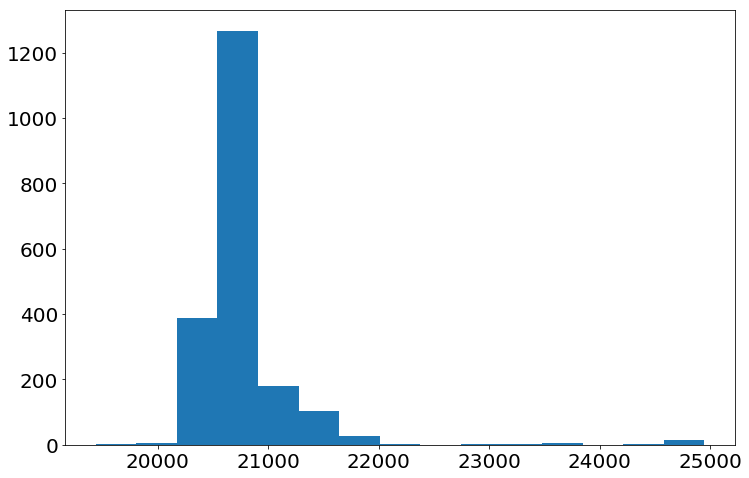

In [23]:
plt.hist(last_mses,bins=15,color='#1f77b4')

# Two step delay - Y - k7 - uM

## Functions

In [24]:
def b0_2D_Y(initals,t,params_constants,params):
    MAP3K, MAP2K, MAPK, X, Y = initals
    MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t, s = params_constants
    beta_0, k1, k3, k5, k7, k9, k2, k4, k6, k8, k10, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    X_I = X_t-X
    Y_I = Y_t-Y

    dMAP3K = (s/(1+Y/beta_0)) * ((k1*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = ((k7*MAPK*X_I) / (K_7+X_I)) - (k8*X/(K_8+X))
    dY = ((k9*X*Y_I) / (K_9+X_I)) - (k10*Y/(K_10+Y))

    return dMAP3K, dMAP2K, dMAPK, dX, dY

def simulate_wt_experiment_2D_Y(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b0_2D_Y, inits, time, args=(params_constants, learned_params))

    return odes

def simulate_t100a_experiment_2D_Y(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_0, k1, k3, k5, k7, k9, k2, k4, k6, k8, k10, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10  = learned_params
    learned_params = beta_0, k1, k3, k5, 0, k9, k2, k4, k6, k8, k10, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10
    #solve odes:
    odes = odeint(b0_2D_Y, inits, time, args=(params_constants, learned_params))

    return odes


## Inputs

In [31]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/180917_b0_2D_k7_Y_uM'

gen = 500
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
Y = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t=100
Y_t=100

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['B0',
              'k1', 'k3', 'k5', 'k7', 'k9',
              'k2', 'k4', 'k6', 'K7', 'k10',
              'K1', 'K3', 'K5', 'k8', 'K9',
              'K2', 'K4', 'K6', 'K8', 'K10'
                ]

mins = [ -4,   -4, -4, -4, -4, -4,    -4, -4, -4, -4, -4,      -4, -4, -4, -4, -4,    -4, -4, -4, -4, -4]

maxs = [4,    4,  4,  4,  4,  4,     4,  4,  4,  4,  4,       4,  4,  4,  4,  4,     4,  4,  4,  4,  4]

diff = np.asarray(maxs)-np.asarray(mins)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X, Y]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t, s] 
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

## Gather simulated data

In [32]:
mse = []
params_from_file = []

empty_data = 0
for loaded_data in pathlib.Path(folder).glob('*.pickled'):
    if os.path.getsize(loaded_data) > 0:
        with open(loaded_data, 'rb') as f:
            new_data = pickle.load(f)
            mse.append(np.asarray(new_data[0]))
            params_from_file.append(np.asarray(new_data[1]))
    else:
        empty_data += 1

top = round((runs-empty_data)*0.05)
plt_top = round((runs-empty_data)*0.01)   
print('Plotting top ' +str(plt_top)+' runs')
    
new_params = []
last_mses = []
for i in range(len(params_from_file)):
    new_params.append(params_from_file[i][gen])
    last_mses.append(mse[i][gen])
last_mses = np.asarray(last_mses)
new_params = np.asarray(new_params)
new_params = new_params.T

idx_top = last_mses.argsort()[:top]

top_params = [([new_params[i][x] for i in range(len(new_params))]) for x in idx_top]
# top_params = []
# for idx in idx_top:
#     top_params.append(params_from_file[idx][100])

print('Best MSE: ' + str(np.min([mse[idx][gen] for idx in idx_top])))

Plotting top 20 runs
Best MSE: 20111.3311957


In [33]:
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

## Plot

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# of unstable WT experiments: 0 of 120
# of unstable T100A experiments: 0 of 120


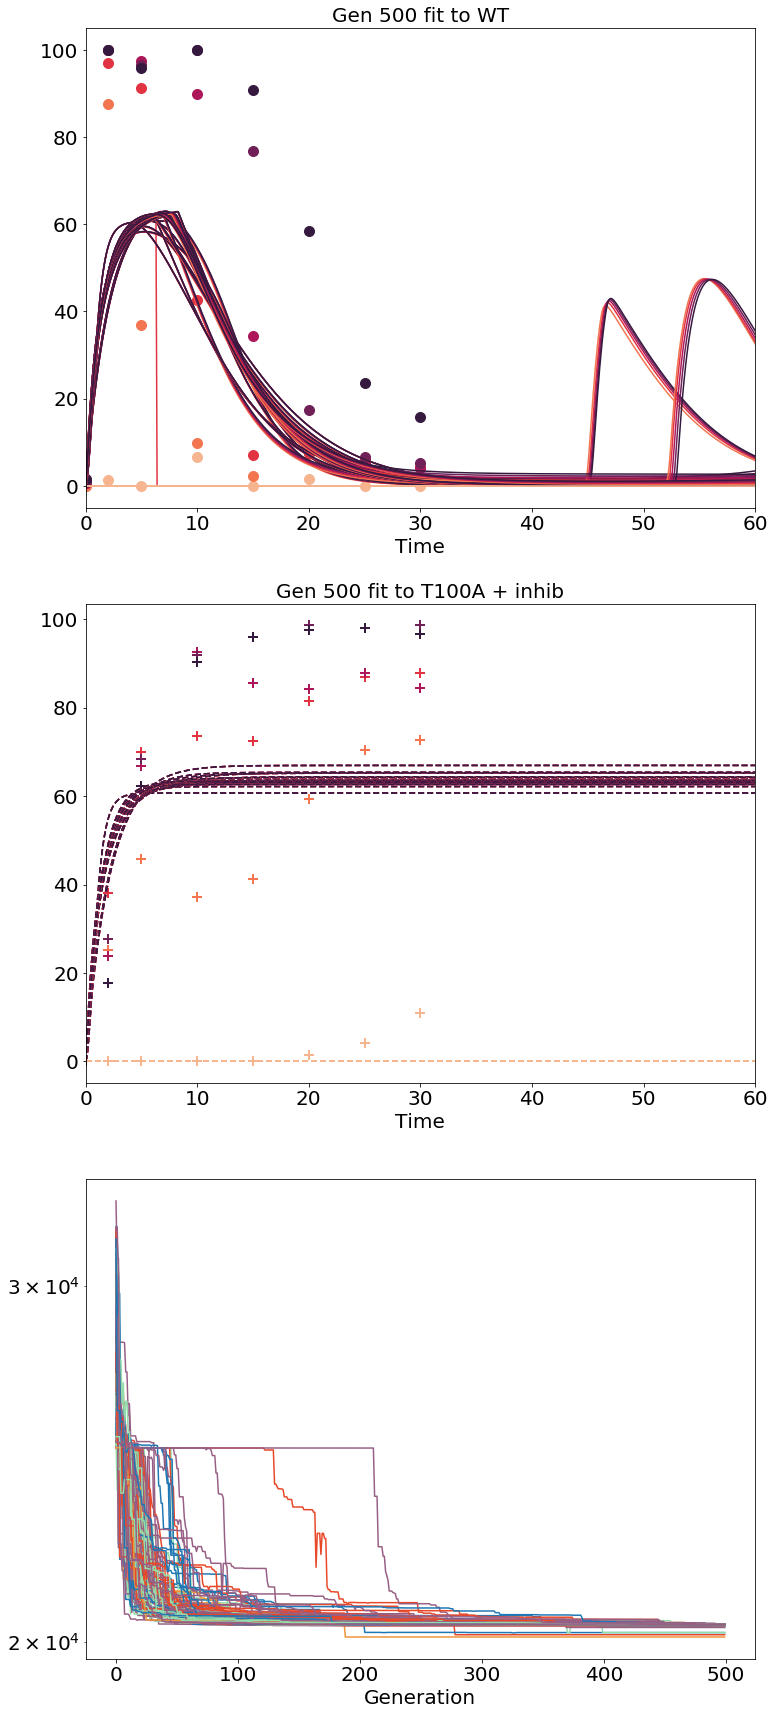

In [35]:
#initialize figure:
plt.clf()
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(12,30))


#plot 1
title_text = 'Gen ' + str(gen) + ' fit to WT'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
color_palette = sns.color_palette("rocket", 6)[::-1]

# plot real data:
for idx, wt_data in enumerate(mapk_wt_data):
    ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
#     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
unstable = 0
for idx in idx_top[:plt_top]:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment_2D_Y(initals, params_c, learned_params, time)
        active = data[:,2]/params_constants[2]*100
        if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            ax1.plot(time, active, color=color_palette[idx])
        else:
            unstable += 1
# ax1.set_ylim(0, 100)
ax1.set_xlim(0,60)
print('# of unstable WT experiments: ' + str(unstable) + ' of ' + str(plt_top*6))
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  ' fit to T100A + inhib'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

for idx, t100a_data in enumerate(mapk_t100a_data):
    ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
unstable = 0
for idx in idx_top[:plt_top]:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment_2D_Y(initals, params_c, learned_params, time)
        active = data[:,2]/params_constants[2]*100
        if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
        else:
            unstable += 1
# ax1.set_ylim(0, 100)
ax2.set_xlim(0,60)
print('# of unstable T100A experiments: ' + str(unstable) + ' of ' + str(plt_top*6))
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#plot2    
ax3.set_xlabel('Generation', fontsize=20)
# ax2.set_ylabel('Sum of MSE', fontsize=20)
# ax3.set_yscale('log')
# ax2.set_xlim([0,gen])
# ax2.set_ylim([10**3,10**5])
for idx in idx_top:
    ax3.semilogy([x for x in range(gen)], mse[idx][:gen])
    

plt.show()

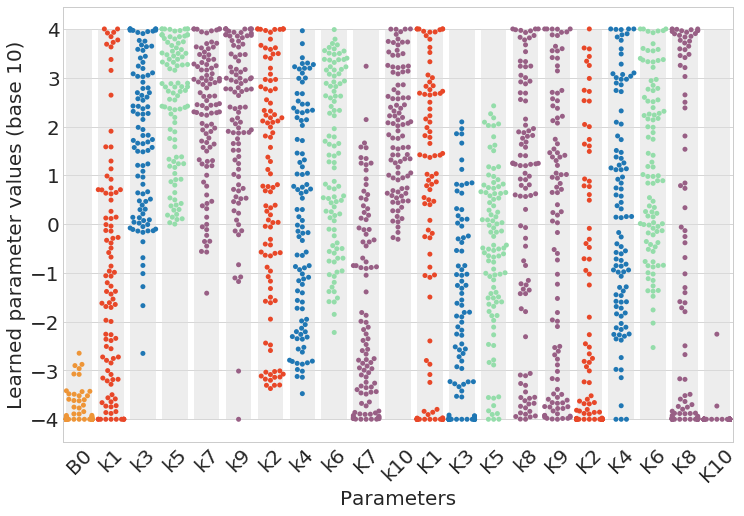

In [29]:
plt.rcParams['figure.figsize'] = [12.0, 8.0]

# positive 3db7d6
# negative ee9537
# hog1 ? 38bf85 or 94ddaa

colors = ['#ee9537',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85']

pal = sns.set_palette(colors)

with sns.axes_style("whitegrid"):
    plt.bar(range(0,len(labelnames)),height=diff,bottom=mins,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
    x = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M)
    x.set_xticklabels(labelnames,rotation=45)
#     ax.set_yscale("log")
#     ax.set_ylim(0.00001,100000)
#     ax4.set_xticks(locs)
#     plt.xticklabels(labelnames, fontsize=18, rotation=90)
    plt.xlabel('Parameters', fontsize=20)
    plt.ylabel('Learned parameter values (base 10)', fontsize=20)
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

(array([  3.28000000e+02,   1.52600000e+03,   8.80000000e+01,
          1.10000000e+01,   7.00000000e+00,   7.00000000e+00,
          4.00000000e+00,   4.00000000e+00,   7.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   2.30000000e+01]),
 array([ 20111.33119568,  20433.73991317,  20756.14863066,  21078.55734815,
         21400.96606564,  21723.37478313,  22045.78350061,  22368.1922181 ,
         22690.60093559,  23013.00965308,  23335.41837057,  23657.82708806,
         23980.23580555,  24302.64452304,  24625.05324053,  24947.46195802]),
 <a list of 15 Patch objects>)

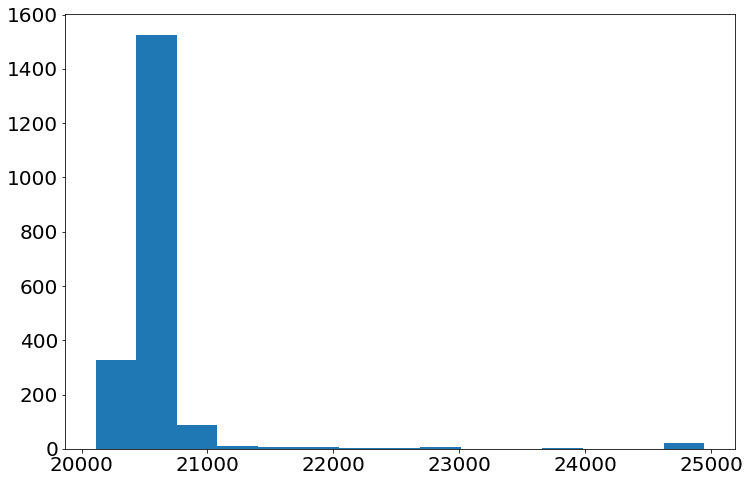

In [30]:
plt.hist(last_mses,bins=15,color='#1f77b4')

# Three step delay - Z - k7 - uM

## Functions

In [43]:
def b0_3D_Z(initals,t,params_constants,params):
    MAP3K, MAP2K, MAPK, X, Y, Z = initals
    MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t, Z_t, s = params_constants
    beta_0, k1, k3, k5, k7, k9, k11, k2, k4, k6, k8, k10, k12, K_1, K_3, K_5, K_7, K_9, K_11, K_2, K_4, K_6, K_8, K_10, K_12 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    X_I = X_t-X
    Y_I = Y_t-Y
    Z_I = Z_t-Z

    dMAP3K = (s/(1+Z/beta_0)) * ((k1*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = ((k7*MAPK*X_I) / (K_7+X_I)) - (k8*X/(K_8+X))
    dY = ((k9*X*Y_I) / (K_9+Y_I)) - (k10*Y/(K_10+Y))
    dZ = ((k11*Y*Z_I) / (K_11+Z_I)) - (k12*Z/(K_12+Z))

    return dMAP3K, dMAP2K, dMAPK, dX, dY, dZ

def simulate_wt_experiment_3D(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b0_3D_Z, inits, time, args=(params_constants, learned_params))

    return odes

def simulate_t100a_experiment_3D(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_0, k1, k3, k5, k7, k9, k11, k2, k4, k6, k8, k10, k12, K_1, K_3, K_5, K_7, K_9, K_11, K_2, K_4, K_6, K_8, K_10, K_12  = learned_params
    learned_params = beta_0, k1, k3, k5, 0, k9, k11, k2, k4, k6, k8, k10, k12, K_1, K_3, K_5, K_7, K_9, K_11, K_2, K_4, K_6, K_8, K_10, K_12
    #solve odes:
    odes = odeint(b0_3D_Z, inits, time, args=(params_constants, learned_params))

    return odes

## Inputs

In [44]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/180917_b0_3D_k7_Z_uM'

gen = 500
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
Y = 0
Z = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t=100
Y_t=100
Z_t = 100

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['B0',
              'k1', 'k3', 'k5', 'k7', 'k9','k11',
              'k2', 'k4', 'k6', 'K7', 'k10','k12',
              'K1', 'K3', 'K5', 'k8', 'K9','K11',
              'K2', 'K4', 'K6', 'K8', 'K10','K12'
                ]

mins = [-4,
        -4, -4, -4, -4, -4, -4,
        -4, -4, -4, -4, -4, -4,
        -4, -4, -4, -4, -4, -4,
        -4, -4, -4, -4, -4, -4]

maxs = [4,
        4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4]

diff = np.asarray(maxs)-np.asarray(mins)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X, Y, Z]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t, Z_t, s]
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

## Gather simulated data

In [45]:
mse = []
params_from_file = []

empty_data = 0
for loaded_data in pathlib.Path(folder).glob('*.pickled'):
    if os.path.getsize(loaded_data) > 0:
        with open(loaded_data, 'rb') as f:
            new_data = pickle.load(f)
            mse.append(np.asarray(new_data[0]))
            params_from_file.append(np.asarray(new_data[1]))
    else:
        empty_data += 1

top = round((runs-empty_data)*0.05)
plt_top = round((runs-empty_data)*0.01)   
print('Plotting top ' +str(plt_top)+' runs')
    
new_params = []
last_mses = []
for i in range(len(params_from_file)):
    new_params.append(params_from_file[i][gen])
    last_mses.append(mse[i][gen])
last_mses = np.asarray(last_mses)
new_params = np.asarray(new_params)
new_params = new_params.T

idx_top = last_mses.argsort()[:top]

top_params = [([new_params[i][x] for i in range(len(new_params))]) for x in idx_top]
# top_params = []
# for idx in idx_top:
#     top_params.append(params_from_file[idx][100])

print('Best MSE: ' + str(np.min([mse[idx][gen] for idx in idx_top])))

Plotting top 20 runs
Best MSE: 19461.3095929


In [46]:
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

## Plot

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# of unstable WT experiments: 0 of 120
# of unstable T100A experiments: 0 of 120


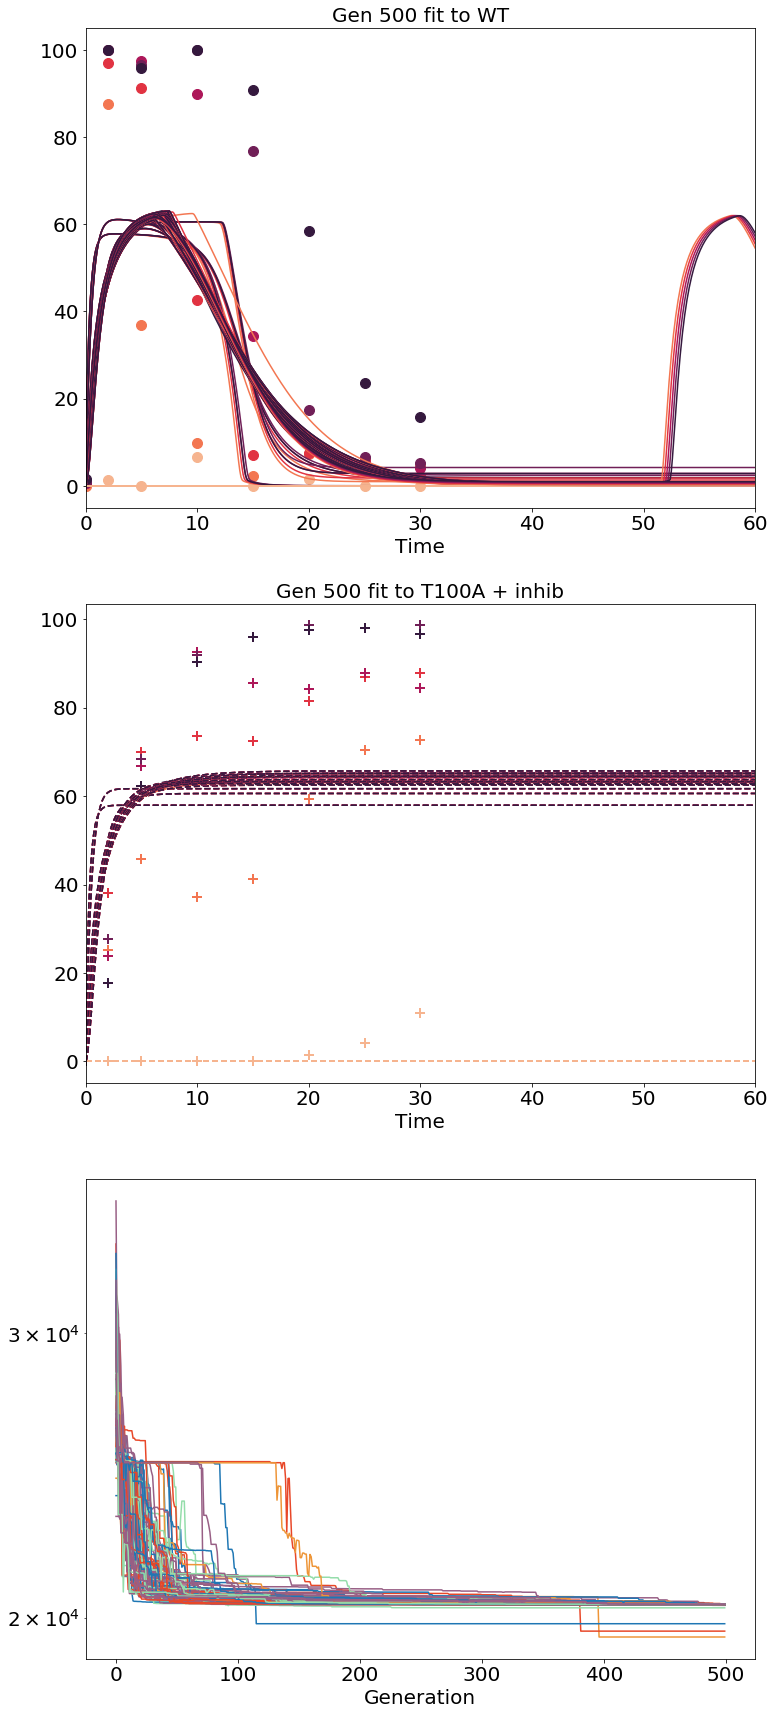

In [47]:
#initialize figure:
plt.clf()
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(12,30))


#plot 1
title_text = 'Gen ' + str(gen) + ' fit to WT'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
color_palette = sns.color_palette("rocket", 6)[::-1]

# plot real data:
for idx, wt_data in enumerate(mapk_wt_data):
    ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
#     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
unstable = 0
for idx in idx_top[:plt_top]:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment_3D(initals, params_c, learned_params, time)
        active = data[:,2]/params_constants[2]*100
        if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            ax1.plot(time, active, color=color_palette[idx])
        else:
            unstable += 1
# ax1.set_ylim(0, 100)
ax1.set_xlim(0,60)
print('# of unstable WT experiments: ' + str(unstable) + ' of ' + str(plt_top*6))
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  ' fit to T100A + inhib'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

for idx, t100a_data in enumerate(mapk_t100a_data):
    ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
unstable = 0
for idx in idx_top[:plt_top]:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment_3D(initals, params_c, learned_params, time)
        active = data[:,2]/params_constants[2]*100
        if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
        else:
            unstable += 1
# ax1.set_ylim(0, 100)
ax2.set_xlim(0,60)
print('# of unstable T100A experiments: ' + str(unstable) + ' of ' + str(plt_top*6))
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#plot2    
ax3.set_xlabel('Generation', fontsize=20)
# ax2.set_ylabel('Sum of MSE', fontsize=20)
# ax3.set_yscale('log')
# ax2.set_xlim([0,gen])
# ax2.set_ylim([10**3,10**5])
for idx in idx_top:
    ax3.semilogy([x for x in range(gen)], mse[idx][:gen])
    

plt.show()

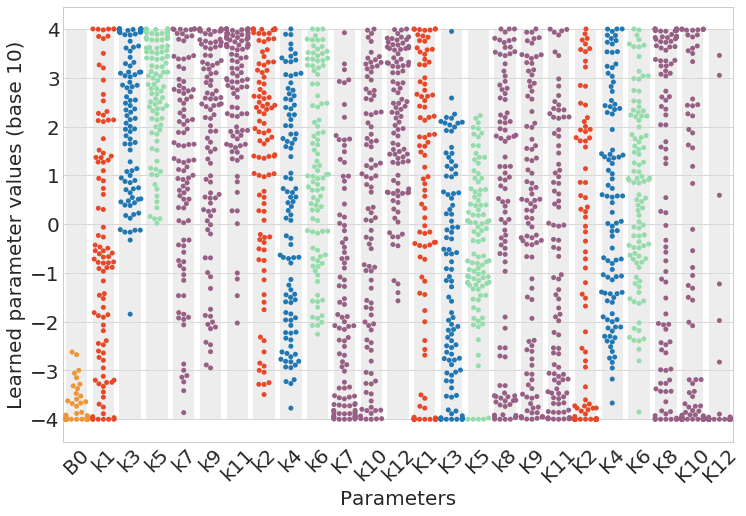

In [49]:
plt.rcParams['figure.figsize'] = [12.0, 8.0]

# positive 3db7d6
# negative ee9537
# hog1 ? 38bf85 or 94ddaa

colors = ['#ee9537',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85','#985f85']

pal = sns.set_palette(colors)

with sns.axes_style("whitegrid"):
    plt.bar(range(0,len(labelnames)),height=diff,bottom=mins,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
    x = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M)
    x.set_xticklabels(labelnames,rotation=45)
#     ax.set_yscale("log")
#     ax.set_ylim(0.00001,100000)
#     ax4.set_xticks(locs)
#     plt.xticklabels(labelnames, fontsize=18, rotation=90)
    plt.xlabel('Parameters', fontsize=20)
    plt.ylabel('Learned parameter values (base 10)', fontsize=20)
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

(array([  2.00000000e+00,   1.00000000e+00,   1.00800000e+03,
          9.18000000e+02,   1.70000000e+01,   6.00000000e+00,
          5.00000000e+00,   8.00000000e+00,   4.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   2.40000000e+01]),
 array([ 19461.30959286,  19828.00492127,  20194.70024967,  20561.39557808,
         20928.09090649,  21294.7862349 ,  21661.48156331,  22028.17689171,
         22394.87222012,  22761.56754853,  23128.26287694,  23494.95820535,
         23861.65353375,  24228.34886216,  24595.04419057,  24961.73951898]),
 <a list of 15 Patch objects>)

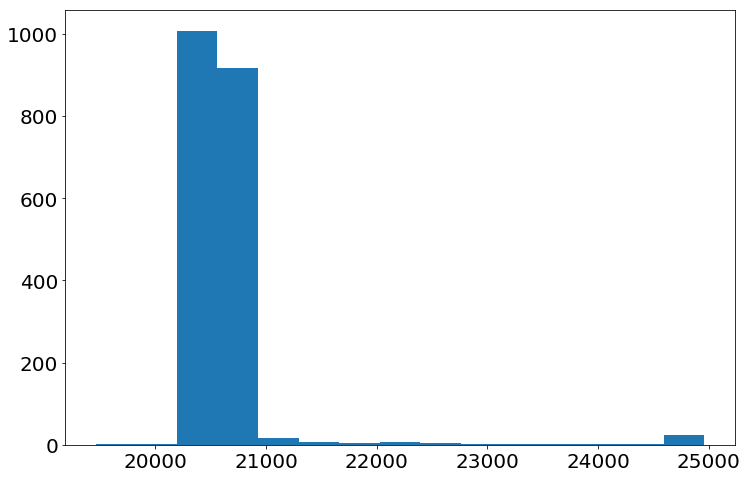

In [50]:
plt.hist(last_mses,bins=15,color='#1f77b4')

# Extra

## Plot MAP2K

In [ ]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9,12))

#plot 1
title_text = 'Gen ' + str(gen) + ' MAP2K WT activation'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,1]
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,60)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  MAP2K T100A mutant activation'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,1]
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,60)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Plot MAP3K

In [ ]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9,12))

#plot 1
title_text = 'Gen ' + str(gen) + ' MAP3K WT activation'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,0]
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,60)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  MAP3K T100A mutant activation'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,0]
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,60)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Plot Active Cytosolic MAPK

In [ ]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9,12))

#plot 1
title_text = 'Gen ' + str(gen) + ' active cytosolic MAPK'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
ax1.set_ylim([0,100])
color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,2]
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,60)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  active cytosolic MAPK'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,2]
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,60)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Plot Active Nuclear MAPK

In [ ]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9,12))

#plot 1
title_text = 'Gen ' + str(gen) + ' nuclear MAPK'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,3]
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,60)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  nuclear MAPK'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,3]
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,60)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Plot X

In [ ]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9,12))

#plot 1
title_text = 'Gen ' + str(gen) + ' active X'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,4]
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,60)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  active X'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,4]
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,60)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Visualize individual param sets

In [ ]:
color_palette = sns.color_palette("rocket", 6)[::-1]

for i, params in enumerate(top_params):
#     beta_1, beta_2, alpha, k1, k2, k3, k4, k5, k6, k7, k8, K_1, K_2, K_3, K_4, K_5, K_6, K_7, K_8, kn, kc = params
#     params = beta_1, beta_2, 0, k1, k2, k3, k4, k5, k6, k7, k8, K_1, K_2, K_3, K_4, K_5, K_6, K_7, K_8, 0, kc
    #plot real data:
    for idx, (wt_data,t100a_data) in enumerate(zip(mapk_wt_data, mapk_t100a_data)):
        plt.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
        plt.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    for idx, signal in enumerate(s):
        data = odeint(b0_D, initals, time, args=(params_constants[:-1]+[signal], params))
        active = data[:,2]+data[:,3]
        plt.plot(time, active, label=str(signal)+' WT active', color=color_palette[idx])
#         plt.plot(time, data[:,4], dashes=[2, 2], label=str(signal)+' X')
        data = simulate_t100a_experiment(initals, params_constants[:-1]+[signal], params, time)
        active = data[:,2]+data[:,3]
        plt.plot(time, active, label=str(signal)+' T100A active', dashes= [4,2], color=color_palette[idx])
#         plt.plot(time, data[:,3], label=str(signal)+' MAPKn')
    plt.title(f'Param set {i}')
    plt.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.ylim(0,100)
    plt.show()

## Compare parameter correlations

In [ ]:
top_params_T = np.asarray(top_params).T

# idx = 18
for idx in range(len(top_params_T)):
    for i in range(len(top_params_T)):
        corr = np.corrcoef(top_params_T[idx],top_params_T[i])[0][1]
        if abs(corr) > 0.6 and abs(corr) < 0.999:
            print(labelnames[idx] + ' vs. '+ labelnames[i])
            print(np.corrcoef(top_params_T[idx],top_params_T[i])[0][1])
#     fig, (ax1,ax2) = plt.subplots(1, 2, figsize= (16,6))
#     ax1.scatter(top_params_T[idx],top_params_T[i])
#     ax1.set_ylabel(labelnames[i])
#     ax1.set_title('Raw')
#     ax2.semilogy(top_params_T[idx],top_params_T[i],'o')
#     ax2.set_xscale('log')
#     ax2.set_title('Log')
#     plt.show()


In [ ]:
idx = 0
for i in range(len(top_params_T)):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize= (16,6))
    ax1.scatter(top_params_T[idx],top_params_T[i])
    ax1.set_ylabel(labelnames[i])
    ax1.set_title('Raw')
    ax2.semilogy(top_params_T[idx],top_params_T[i],'o')
    ax2.set_xscale('log')
    ax2.set_title('Log')
    plt.show()


# Model investigation

In [ ]:
top_params = [([new_params[i][x] for i in range(len(new_params))]) for x in idx_top]

In [ ]:
print(top_params[0])
beta_0,    k0, k1, k3, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8,   X_t = top_params[0]
top_params[0] = beta_0,    k0, k1, .1, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8,   X_t
for idx, sig in enumerate(params_constants[-1]):
    params_c = params_constants[:-1]+[sig]
    data = simulate_wt_experiment(initals, params_c, top_params[0], time)
    active = (data[:,2] + data[:,3])/params_constants[2]*100
    plt.plot(time, active, color=color_palette[idx])
    plt.ylim(0,100)

# Results Notes 